**1. Import libraries**

In [ ]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import scipy.integrate
import copy


from scipy.integrate import solve_ivp
from scipy.optimize  import minimize, differential_evolution
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.linear_model    import BayesianRidge

**2. Read data from CSSEGISandData/COVID-19**

In [ ]:
class CovidData:
    def __init__(self):
        url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
        url_death = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
        url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
        
        self.cases_glob_df  = pd.read_csv(url_confirmed)
        self.deaths_glob_df = pd.read_csv(url_death)
        self.recovs_glob_df = pd.read_csv(url_recovered)

    def __anyDup(self, thelist):
        ''' 
        returns a set of duplicates in the list
        '''
        seen = set()
        dups = []
        for x in thelist:
            if x in seen:
                dups.append(x)
            seen.add(x)
        return set(dups);

    def __getDupCountries(self):
        '''
        returns all of the duplicate countries in the data
        '''
        countries = self.cases_glob_df;
        dup_countries = list( self.__anyDup(countries) );
        return dup_countries;

    def __sep_loc_dfs(self, location):
        '''
        returns 3 dataframes in a particular location
        '''
        cas_df = self.cases_glob_df.loc  [self.cases_glob_df  ['Country/Region'] == location];
        dea_df = self.deaths_glob_df.loc [self.deaths_glob_df ['Country/Region'] == location];
        rec_df = self.recovs_glob_df.loc [self.recovs_glob_df ['Country/Region'] == location];
        return cas_df, dea_df, rec_df

    def __trimDfByStartDate(self, df) :
        cols = list(df);
        count = 0;
        for col in cols:
            if df[col].sum() == 0:
                count +=1;
            else:
                break;
        if count == 0:
            return df;
        else:
            df = df.iloc[ : , count:]
            return df;

    def get(self, location = "Total"):
        '''
        the get method returns a dataframe that contains the total cases, deaths, and recovories every day for a location of interest.
        If no location is passed in, then the function will return a data frame that sums the cases, deaths, and recoveries of every country
        '''
        if location != "Total":            
            if location not in self.__getDupCountries():
                cas_df , dea_df , rec_df = self.__sep_loc_dfs(location);
                dates = list(cas_df.columns[4:]);
                dic = {};
                for date in dates:
                    dic[str(date)] = [(list(cas_df[date])[0]) , (list(dea_df[date])[0]) , (list(rec_df[date])[0])];
                df = pd.DataFrame.from_dict(dic)
                df = self.__trimDfByStartDate(df);
                df = df.transpose();
                df.columns = ['Cases','Deaths','Recoveries'];

            else:
                # In case country has multiple provincies, just sum it up
                cas_df , dea_df , rec_df = self.__sep_loc_dfs(location);
                dates = list(self.cas_df.columns[4:]);
                dic = {};
                for date in dates:
                    dic[str(date)] = [(self.cas_df[date].sum()) ,(self.dea_df[date].sum()) , (self.rec_df[date].sum())]
                df = pd.DataFrame.from_dict(dic)
                df = self.__trimDfByStartDate(df);
                df = df.transpose();
                df.columns = ['Cases','Deaths','Recoveries'];
        else:
            dates = list(self.cases_glob_df.columns[4:]);
            dic = {};
            for date in dates:
                dic[str(date)] = [(self.cases_glob_df[date].sum()) ,(self.deaths_glob_df[date].sum()) , (self.recovs_glob_df[date].sum())]
            df = pd.DataFrame.from_dict(dic).transpose();
            df.columns = ['Cases','Deaths','Recoveries'];
        return df;

    def getSIRD_df(self, location, population):
        loc_df = self.get(location)
        loc_df['SIR_Suceptible'] = (population - (loc_df['Cases']))
        loc_df['SIR_Infected']   = (loc_df['Cases'] - loc_df['Deaths'] - loc_df['Recoveries'])
        loc_df['SIR_Recovered']  = (loc_df['Recoveries'])
        loc_df['SIR_Deaths']     = loc_df['Deaths']
 
        SIR_df = loc_df.loc[:, loc_df.columns.intersection(['SIR_Suceptible','SIR_Infected','SIR_Recovered', 'SIR_Deaths' ])]

        return SIR_df

    def get_closed_active_cases_df(self, location):
        loc_df = self.get(location)
        loc_df['Closed Cases'] = loc_df['Deaths']    + loc_df['Recovered']
        loc_df['Active Cases'] = loc_df['Confirmed'] - loc_df['Closed Cases']
        active_closed_df = loc_df.loc[:, loc_df.columns.intersection(['Active Cases','Closed Cases'])]
        return active_closed_df


**3. Build SIRD_plots class, which contains functions to plot the result of SIRD model and S,I,R,D Comparison**

In [ ]:
class SIRD_plots:
    def __init__(self, country, population, beta, gamma, mu, s0, i0, r0, d0, SIR_df = None):
        '''
        SIR_plots constructor. Takes in the name of the country, population, 
        beta value, gamma value, inital SIR conditions, and an SIR dataframe
        to display plots to analyze the SIR model
        '''
        self.country = country;
        self.pop = population;
        self.beta = beta;
        self.gamma = gamma;
        self.mu    = mu
        self.s0 = s0;
        self.i0 = i0;
        self.r0 = r0;
        self.d0 = d0;
        self.df = SIR_df;

    def __SIRD_model (self, y, t, beta, gamma, mu):
        '''
        __SIR_model is a private method that computes the
        SIR differentials
        '''
        S, I, R, D = y;
        dS_dt   = (-beta*S*I)/self.pop;
        dI_dt   = (((beta*S*I)/self.pop) - (gamma*I)) - (mu*I)
        dR_dt   = (gamma*I);
        dD_dt   = (mu*I)
        return    ([ dS_dt , dI_dt , dR_dt, dD_dt ]);

    def __init_plots(self):
        plt.figure(figsize = [7,5]);

    def __plot_details(self, title, x, y):
        plt.title (self.country + " " + title , size = 25);
        plt.xlabel(x , size = 16);
        plt.ylabel(y , size = 16);
        plt.legend(prop = {'size' : 20});
        plt.show();

    def plot_SIRD_model (self,time):
        t = np.linspace(1,time,10000)
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution)
    
        self.__init_plots()
    
        plt.plot(t , solution[:, 0] , label = "S(t)" , color = 'blue')
        plt.plot(t , solution[:, 1] , label = "I (t)" , color = 'red')
        plt.plot(t , solution[:, 2] , label = "R (t)" , color = 'green')
        plt.plot(t , solution[:, 3], label = "D (t)" , color = 'orange')

        self.__plot_details("SIRD Model " + str(time) + " Days" , "Time", "Number of people")


    def S_Comparision (self):
        time = self.df.shape[0]
        t = np.linspace(1,time,10000)
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution)
        self.__init_plots()
    
        plt.plot(t , solution[:, 0] , '--', label = "S(t)" , color = 'blue')
        plt.plot(self.df['SIR_Suceptible'], label = "Suceptible Plot", color = 'blue')
        self.__plot_details("Suceptible Comparision", "Days", "Number of people")

    def I_Comparision (self):
        time = self.df.shape[0]
        t = np.linspace(1,time,10000)
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution)
        self.__init_plots()

        plt.plot(t , solution[:, 1] , '--', label = "I(t)" , color = 'red');
        plt.plot(self.df['SIR_Infected'] , label = "Infected Plot"  , color = 'red');

        self.__plot_details("Infected Comparision", "Days", "Number of people");

    def R_Comparision (self):
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
    
        plt.plot(t , solution[:, 2] , '--', label = "R(t)" , color = 'green');
        plt.plot(self.df['SIR_Recovered'] , label = "Recovered Plot" , color = 'green');
    
        self.__plot_details("Recovered Comparision", "Days", "Number of people");

    def D_Comparision (self):
        time = self.df.shape[0]
        t = np.linspace(1,time,10000);
        solution = scipy.integrate.odeint(self.__SIRD_model, [self.s0, self.i0, self.r0, self.d0], t, args = (self.beta, self.gamma, self.mu))
        solution = np.array(solution);
    
        plt.plot(t , solution[:, 3] , '--', label = "D(t)" , color = 'orange');
        plt.plot(self.df['SIR_Deaths'] , label = "Deaths Plot" , color = 'orange');
    
        self.__plot_details("Death Comparision", "Days", "Number of people");

**4. Build SIRD model**

In [ ]:
def SIRD_model (y, t, beta, gamma, mu, pop):
    S, I, R, D = y;
    dS_dt   = (-beta*S*I)/pop;
    dI_dt   = (((beta*S*I)/pop) - (gamma*I)) - (mu*I)
    dR_dt   = (gamma*I);
    dD_dt   = (mu*I)
    return    ([ dS_dt , dI_dt , dR_dt, dD_dt ])

In [ ]:
def get_SIRD_initials (SIR_df):
    SIR_0 = list(SIR_df.iloc[0 , :]);
    SIR_0 = [SIR_0[0],1,0,0]
    return SIR_0[0] , SIR_0[1], SIR_0[2], SIR_0[3]

**5. Build loss function (RMSE)**

In [ ]:
def RMSE(point, data, s0, i0, r0, d0, pop):
    beta, gamma, mu = point
    size = len(data)
    
    def SIRD(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        D = y[3]
        return [(-beta*S*I/pop), (beta*S*I/pop) - gamma*I - mu*I,gamma*I, mu*I]

    solution = solve_ivp(SIRD, [0, size], [s0, i0, r0, d0], t_eval = np.arange(0, size, 1), vectorized=True);
    
    l0 = np.sqrt(np.mean((solution.y[0] - data['SIR_Suceptible'])**2));
    l1 = np.sqrt(np.mean((solution.y[1] - data['SIR_Infected'  ])**2));
    l2 = np.sqrt(np.mean((solution.y[2] - data['SIR_Recovered' ])**2));
    l3 = np.sqrt(np.mean((solution.y[3] - data['SIR_Deaths'    ])**2));
    
    return (0.25 * l0) + (0.25 * l1) + (0.25 * l2) + (0.25 * l3)

In [ ]:
def trainSIRD(countrySIRdf, population, s0, i0, r0, d0):
    # Local min
    optimal = minimize(RMSE,[0.001, 0.001, 0.001], args = (countrySIRdf, s0, i0, r0,d0, population), method = 'L-BFGS-B', bounds = [(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)])
    beta , gamma, mu = optimal.x;
    return beta , gamma, mu

In [ ]:
def setDaysSinceIndex (df):
    dateList = list(df.index);
    days = int(df.shape[0])
    daysSinceLst = [];
    count = 0;
    for i in range(days):
        count+=1;
        daysSinceLst.append(count);
    df = df.set_index(pd.Index(daysSinceLst));
    return df

**6. Build a Bayes Ridge polynomial regression model**

In [ ]:
def polyBayRidgePredicter (X_train, y, y_train, y_test) :
    tol      = [1e-4, 1e-3, 1e-2];
    alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4];
    alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4];
    lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4];
    lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4];

    bayesian_grid = {'tol'     : tol,
                     'alpha_1' : alpha_1,
                     'alpha_2' : alpha_2,
                     'lambda_1': lambda_1,
                     'lambda_2': lambda_2 }

    poly         = PolynomialFeatures(degree=5);
    poly_y_train = poly.fit_transform(y_train);
    poly_y_test  = poly.fit_transform(y_test);
    poly_y       = poly.fit_transform(y);

    bayesian = BayesianRidge(fit_intercept=False, normalize=True);
    bayesian_search_poly = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
    bayesian_search_poly.fit(poly_y_train, X_train);
    print(bayesian_search_poly.best_params_);
    
    bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
    test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_y_test)
    bayesian_poly_pred      = bayesian_poly_confirmed.predict(poly_y)

    return bayesian_poly_pred

In [ ]:
def plotPolyBayRidgePrediction(X, y, X_train, y_train, bayesian_poly_pred) :
    plt.figure(figsize=(15, 10))
    plt.plot(y,
             X,
             label = 'Actual Future Infections',
             color = 'blue')
    plt.plot(y,
             bayesian_poly_pred,
             label = 'Ridge Polynomial Prediction of Future Infections',
             linestyle = "dashed",
             color = 'red')
    plt.plot(y_train,
             X_train,
             label = 'Training Set',
             color = 'green')

    plt.title('Polynomial Bayesian Ridge Regression Prediciton of Infected Population', size=20)
    plt.xlabel('Days', size = 20)
    plt.ylabel('Number of Infections', size = 20)
    #plt.grid()
    plt.legend(prop = {'size' : 15})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [ ]:
def plotRidge_And_IPrediction(X, y, X_train, y_train, bayesian_poly_pred, solution, pop) :
    plt.figure(figsize=(10, 10))
    plt.plot(y,
             X,
             label = 'Actual Future Infections',
             color = 'blue')
    plt.plot(y,
             bayesian_poly_pred,
             label = 'Ridge Polynomial Prediction of Future Infections',
             linestyle = "dashed",
             color = 'red')
    
    time = len(X)
    t = np.linspace(1,time,10000);
    plt.plot(t , solution[:, 1] , label = "SIRD I(t) Prediction" , color = 'green');

    plt.plot(y_train,
             X_train,
             label = 'Training Set',
             color = 'orange')

    plt.title('Prediction Comparision of Infected Population', size=20)
    plt.xlabel('Days', size = 20)
    plt.ylabel('Number of Infections', size = 20)
    plt.legend(prop = {'size' : 15})
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.show()

In [ ]:
def predictSIRD(df, beta , gamma, mu, s0, i0, r0, d0, pop) :
    time = df.shape[0]
    t = np.linspace(1,time,10000);
    solution = scipy.integrate.odeint(SIRD_model, [s0, i0, r0, d0], t, args = (beta, gamma, mu, pop))
    solution = np.array(solution);
    return solution

In [ ]:
def trainTestSplitDataFrame (df, trainSize):
    nRows = df.shape[0]
    nTrainRows = nRows*trainSize//100
    nTestRows = nRows - nTrainRows
    trainDf = df.iloc[:nTrainRows , :]
    testDf  = df.iloc[nTrainRows: , :]
    return trainDf , testDf

**7. Filter out data in US only**

In [ ]:
country = 'US'
population = 331002651

In [ ]:
data = CovidData()
df = data.getSIRD_df(country, population)
df = df.iloc[ :- 1 , :]
df = setDaysSinceIndex(df)
#test
print(df)

     SIR_Suceptible  SIR_Infected  SIR_Recovered  SIR_Deaths
1         331002650             1              0           0
2         331002650             1              0           0
3         331002649             2              0           0
4         331002649             2              0           0
5         331002646             5              0           0
..              ...           ...            ...         ...
193       326382059       3003548        1461885      155159
194       326334479       3043918        1468689      155565
195       326289111       3043990        1513446      156104
196       326231571       3084619        1528979      157482
197       326178761       3087185        1577851      158854

[197 rows x 4 columns]


In [ ]:
s0, i0, r0, d0 = get_SIRD_initials(df)
trainDf , testDf = trainTestSplitDataFrame(df, trainSize)
beta , gamma, mu = trainSIRD(trainDf, population, s0, i0, r0, d0)
print('Beta = ',beta)
print('Gamma = ', gamma)
print('Mu = ', mu)

Beta =  0.1275683213242846
Gamma =  0.040063523380211796
Mu =  0.005291731933752999


In [ ]:
solution = predictSIRD(df, beta , gamma, mu, s0, i0, r0, d0, population)
country_plots = SIRD_plots(country, population, beta, gamma, mu, s0, i0, r0, d0, df)

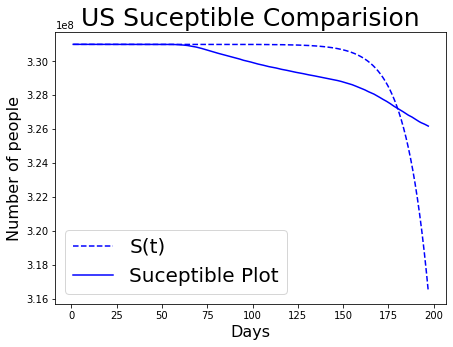

In [ ]:
country_plots.S_Comparision()

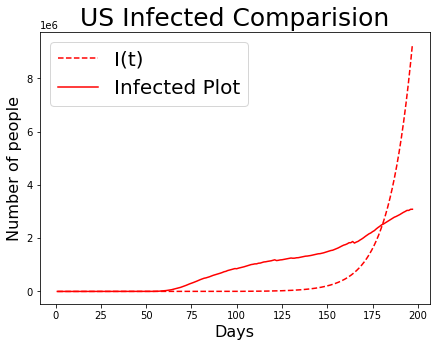

In [ ]:
country_plots.I_Comparision()

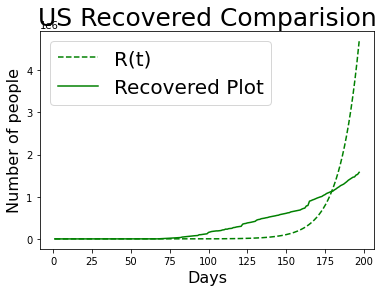

In [ ]:
country_plots.R_Comparision()

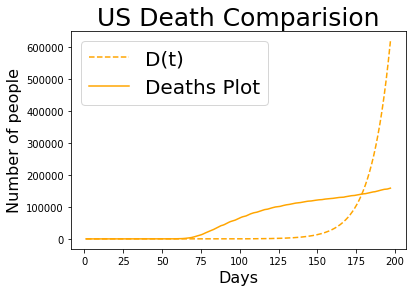

In [ ]:
country_plots.D_Comparision()

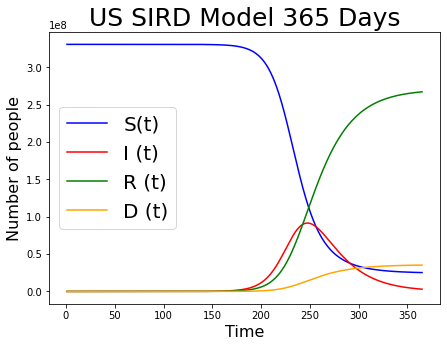

In [ ]:
country_plots.plot_SIRD_model(365)

**8. Give a prediction for number of infected people (I) in the future. Compare SIRD model with Bayes Ridge Polynomial regression**

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished


{'tol': 0.01, 'lambda_2': 1e-06, 'lambda_1': 0.0001, 'alpha_2': 1e-05, 'alpha_1': 1e-05}


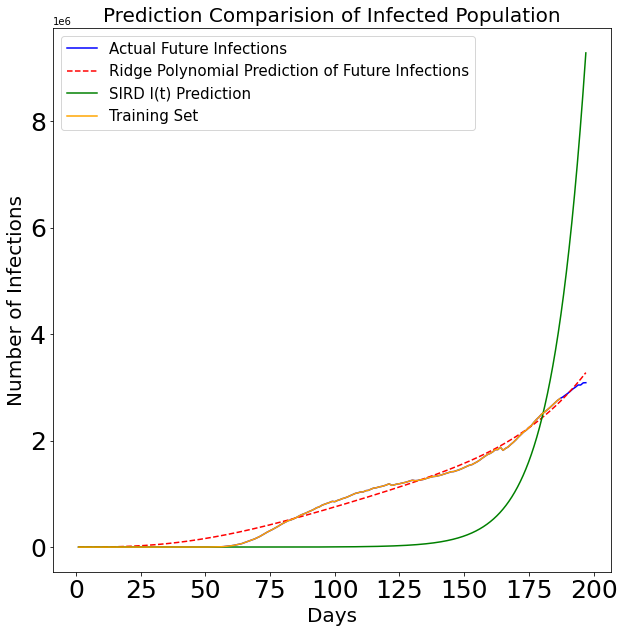

In [ ]:
trainSize = 95
X = np.array(df["SIR_Infected"]);
y = np.array(df.index).reshape(-1,1);
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ((100 - trainSize)/100), shuffle = False);
bayesian_poly_pred = polyBayRidgePredicter(X_train, y, y_train, y_test)
#plotRidgeAndSIRPrediction(X, y, X_train, y_train, bayesian_poly_pred, solution, population)
plotRidge_And_IPrediction(X, y, X_train, y_train, bayesian_poly_pred, solution, population)